In [373]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os

"""
Exploring datas from the projectg Helpdesk-Tickets
"""

issues = pd.read_csv('/home/hebert/Helpdesk-Tickets/data/raw/issues.csv')
#print(issues.tail(10))
#issues.info()

snapshot = pd.read_csv('/home/hebert/Helpdesk-Tickets/data/raw/issues_snapshot.csv')
#print(snapshot.head(10))
#snapshot.info()

utterances = pd.read_csv('/home/hebert/Helpdesk-Tickets/data/raw/sample_utterances.csv')
#print(utterances.tail(10))
#utterances.info()

assignee_scoring = pd.read_excel('/home/hebert/Helpdesk-Tickets/data/raw/issues_snapshot_sample.xlsx')
#print(assignee_scoring.tail(10))
#assignee_scoring.info()

change_history = pd.read_csv('/home/hebert/Helpdesk-Tickets/data/raw/issues_change_history.csv')
#print(change_history.tail(10))
#change_history.info()
#print(issues.head(10))


In [374]:
#Cleaning the issues.csv

#print(issues.isna().sum())
#print(issues['issue_resolution_date'].value_counts())
#print(issues['issue_resolution'].value_counts())

issues['issue_assignee'].fillna('unassigned', inplace = True)
issues = issues.dropna(subset = ['issue_resolution_date', 'issue_resolution'], how = 'all')

issues = issues.drop(['wf_in_review','wf_deployment','wf_resolved','wf_monitoring','wf_done','wf_pending_customer_approval','wf_rejected','wf_testing_monitoring',
                        'wf_in_progress','wf_reopened','wf_to_do','wf_validation','wf_resolved_under_monitoring','wf_closed','wf_waiting','wf_cancelled', 'wf_under_review',
                        'wf_approved', 'wf_pending_deployment'], axis = 1)
#print(issues.isna().sum())
#print(issues.head(10))
#issues is clean



In [375]:
#Correction types

#print(issues.isna().sum())
#print(issues.head(10))
#print(issues.info())

#id from float to in
issues['id'] = issues['id'].astype('Int64')

#started from object to timestamp
issues['started'] = pd.to_datetime(issues['started'], format='ISO8601', utc=True)
#print(issues.info())

#ended from object to timestamp
issues['ended'] = pd.to_datetime(issues['ended'], format='ISO8601', utc=True)
#print(issues.info())

# Variable 'proj_type' decoded FEATURES.md
issues['proj_type'] = 'internal'          # Default: internal
issues['country_code'] = 'internal'        # Default: internal
issues['client_product'] = 'internal'      # Default: internal
external_mask = (issues['issue_proj'].str.len() > 6) & (issues['issue_proj'].str.startswith('C', na=False))
matches = issues.loc[external_mask, 'issue_proj'].str.match(r'^(C\d{2})(.+)$')
issues.loc[external_mask, 'proj_type'] = 'external'
issues.loc[external_mask & matches, 'country_code'] = issues.loc[external_mask & matches, 'issue_proj'].str.extract(r'^(C\d{2})')[0]
issues.loc[external_mask & matches, 'client_product'] = issues.loc[external_mask & matches, 'issue_proj'].str.extract(r'^C\d{2}(.+)$')[0]
issues.loc[issues['issue_proj'].isna(), ['proj_type', 'country_code', 'client_product']] = 'unknown'

#issues['proj_type'].value_counts()
#issues['country_code'].value_counts()
#issues['client_product'].value_counts()

#issue_created from object to timestamp
issues['issue_created'] = pd.to_datetime(issues['issue_created'], format='ISO8601', utc=True)

#issue_resolution_date from object to timestamp
issues['issue_resolution_date'] = pd.to_datetime(issues['issue_resolution_date'], format='ISO8601', utc=True)


#last_change_date from object to timestamp
issues['last_change_date'] = pd.to_datetime(issues['last_change_date'], format='ISO8601', utc=True)


#issues['client_product'].value_counts()

#issues.tail(10)
#print(issues.info())


In [376]:
#issues.describe()

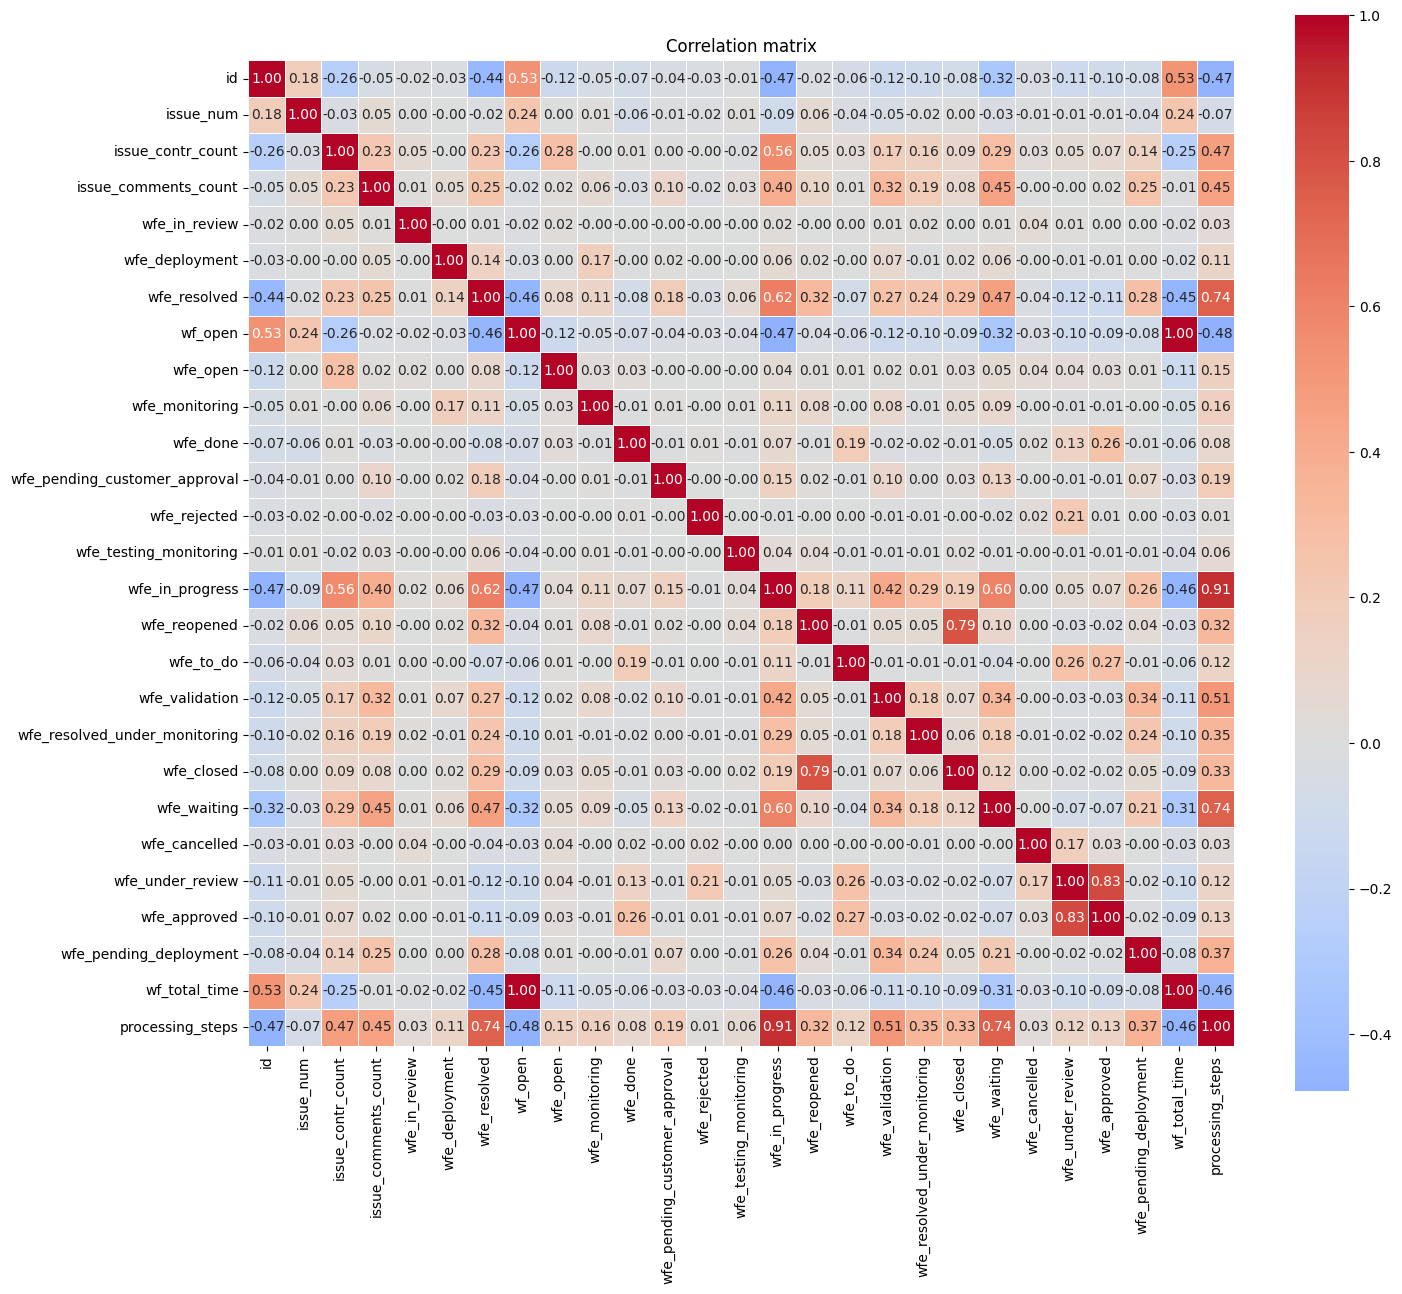


Top 20 positive Korrelationen (gesamt):
           Variable1                     Variable2  Correlation
             wf_open                 wf_total_time     0.997955
    processing_steps               wfe_in_progress     0.907882
        wfe_approved              wfe_under_review     0.827900
          wfe_closed                  wfe_reopened     0.792161
    processing_steps                   wfe_waiting     0.744919
    processing_steps                  wfe_resolved     0.741145
     wfe_in_progress                  wfe_resolved     0.617569
     wfe_in_progress                   wfe_waiting     0.602573
   issue_contr_count               wfe_in_progress     0.563392
                  id                       wf_open     0.534261
                  id                 wf_total_time     0.529180
    processing_steps                wfe_validation     0.512112
   issue_contr_count              processing_steps     0.474062
        wfe_resolved                   wfe_waiting     0.468278

In [379]:
#Looking for correlation
numeric_issues = issues.select_dtypes(include=['number', 'float64', 'int64'])
corr_matrix_issues = numeric_issues.corr()
#display(corr_matrix_issues)


plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix_issues, 
            annot=True,          # Zahlen in die Felder schreiben
            fmt=".2f",           # 2 Nachkommastellen
            cmap='coolwarm',     # Rot-Blau-Farbskala (positiv/negativ)
            center=0,            # 0 zentriert
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .8})
plt.title('Correlation matrix')
plt.tight_layout()
plt.show()

corr_unstacked = corr_matrix_issues.unstack().reset_index()
corr_unstacked.columns = ['Variable1', 'Variable2', 'Correlation']
corr_unstacked = corr_unstacked[corr_unstacked['Variable1'] < corr_unstacked['Variable2']].copy()
corr_unstacked = corr_unstacked.dropna()
top_positive = corr_unstacked.sort_values('Correlation', ascending=False).head(20)
top_negative = corr_unstacked.sort_values('Correlation', ascending=True).head(20)
top_exact_plus1 = corr_unstacked[corr_unstacked['Correlation'] == 1.0].head(20)
top_exact_minus1 = corr_unstacked[corr_unstacked['Correlation'] == -1.0].head(20)

print("\nTop 20 positive Korrelationen (gesamt):")
print(top_positive.to_string(index=False))

print("\nTop 20 negative Korrelationen (gesamt):")
print(top_negative.to_string(index=False))

print("\nTop 20 Paare mit exakt +1.0 Korrelation:")
if len(top_exact_plus1) > 0:
    print(top_exact_plus1.to_string(index=False))
else:
    print("Keine Paare mit exakter Korrelation von +1.0 gefunden.")

print("\nTop 20 Paare mit exakt -1.0 Korrelation:")
if len(top_exact_minus1) > 0:
    print(top_exact_minus1.to_string(index=False))
else:
    print("Keine Paare mit exakter Korrelation von -1.0 gefunden.")


Shape von numeric_issues_dummies: (65838, 69)
Anzahl Dummiespaltenspalten: 42
Beispiel-Korrelationsmatrix (erste 10x10):
                            id  issue_num  issue_contr_count  \
id                    1.000000   0.177728          -0.255270   
issue_num             0.177728   1.000000          -0.027616   
issue_contr_count    -0.255270  -0.027616           1.000000   
issue_comments_count -0.047899   0.050099           0.231668   
wfe_in_review        -0.017146   0.002430           0.051334   
wfe_deployment       -0.027309  -0.000285          -0.000628   
wfe_resolved         -0.436100  -0.020886           0.227982   
wf_open               0.534261   0.242165          -0.261781   
wfe_open             -0.120056   0.000037           0.276031   
wfe_monitoring       -0.052886   0.008681          -0.003248   

                      issue_comments_count  wfe_in_review  wfe_deployment  \
id                               -0.047899      -0.017146       -0.027309   
issue_num           

'\nplt.figure(figsize=(20, 20))\nsns.heatmap(corr_matrix_issues_dummies, \n            annot=True,          # Zahlen in die Felder schreiben\n            fmt=".2f",           # 2 Nachkommastellen\n            cmap=\'coolwarm\',     # Rot-Blau-Farbskala (positiv/negativ)\n            center=0,            # 0 zentriert\n            square=True,\n            linewidths=.5,\n            cbar_kws={"shrink": .8})\nplt.title(\'Correlation matrix dummies\')\nplt.tight_layout()\nplt.show()\n'

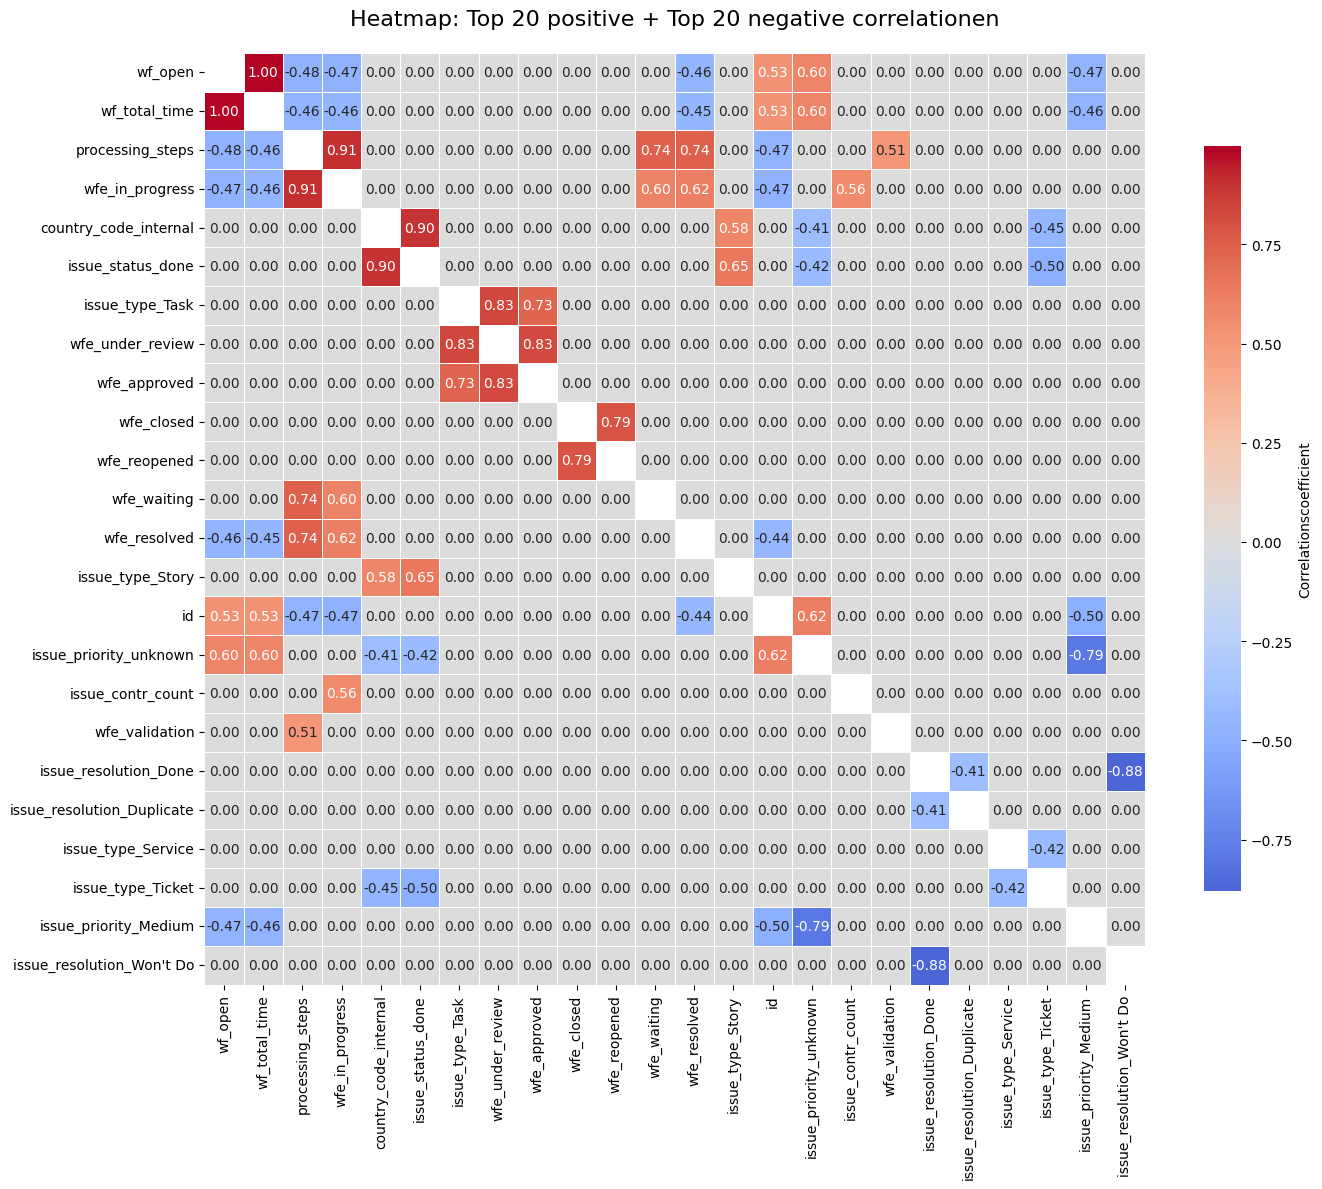

In [383]:
#issues_dummies = pd.get_dummies(issues, columns = ['country_code','proj_type','issue_type','issue_priority','issue_proj','issue_assignee',
#                                                  'issue_type', 'issue_resolution', 'issue_status', 'client_product'])

#    Select categorical columns that you want to dummy-code
#    Choose wisely – too many unique values (e.g., issue_proj has ~358) will generate a lot of columns!
categorical_cols = [
    'issue_type',        # 15 Kategorien → easy
    'issue_priority',    # 7 Kategorien → easy
    'issue_resolution',  # 4 Kategorien → easy
    'issue_status',      # 15 Kategorien → ok
    'country_code',      # 19 Kategorien → ok
    #'issue_proj',      # Attention: ~358 unique → producted ~357 dummies → very wide!
    #'issue_reporter',  # ~1114 unique → extrem much dummies → better to omit or group together
    #'issue_assignee'   # ~381 unique + much NA → same
]

# Remove columns that do not exist (for safety's sake)
categorical_cols = [col for col in categorical_cols if col in issues.columns]

# Automatically select numeric columns (int/float)
numeric_cols = issues.select_dtypes(include=['int64', 'float64']).columns.tolist()

# DataFrame with only numeric + desired categorical columns
issues_selected = issues[numeric_cols + categorical_cols].copy()

# Create dummy variables
#    - dtype=int → directly 0 and 1 (no True/False)
#    - drop_first=True → avoids multicollinearity (one category becomes reference)
issues_with_dummies = pd.get_dummies(
    issues_selected,
    columns=categorical_cols,
    drop_first=True,
    dtype=int
)

# Final DataFrame: ONLY numeric columns (original num + dummies as 0/1)
numeric_issues_dummies = issues_with_dummies.select_dtypes(include=['int64', 'float64', 'int32'])

# Calculate correlation matrix
corr_matrix_issues_dummies = numeric_issues_dummies.corr()

# Control issue
print("Shape von numeric_issues_dummies:", numeric_issues_dummies.shape)
print("Anzahl Dummiespaltenspalten:", len(numeric_issues_dummies.columns) - len(numeric_cols))
print("Beispiel-Korrelationsmatrix (erste 10x10):")
print(corr_matrix_issues_dummies.iloc[:10, :10])


#Save path for big correlation matrix
save_path = '/home/hebert/Helpdesk-Tickets/data/processed/correlation_matrix.csv'
os.makedirs(os.path.dirname(save_path), exist_ok=True)


#Creat csv
corr_matrix_issues_dummies.to_csv(save_path)
print(f"Correlationsmatrix saved under: {save_path}")

# Evaluation: Top 20 positive and negative correlations
corr_unstacked = corr_matrix_issues_dummies.unstack().reset_index()
corr_unstacked.columns = ['Variable1', 'Variable2', 'Correlation']
corr_unstacked = corr_unstacked[corr_unstacked['Variable1'] < corr_unstacked['Variable2']]

#Remove duplicates (only consider A < B)
top_positive = corr_unstacked.sort_values('Correlation', ascending=False).head(20)
top_negative = corr_unstacked.sort_values('Correlation', ascending=True).head(20)


# Output
print("\nTop 20 positive correlationen:")
print(top_positive.to_string(index=False))

print("\nTop 20 negative correlationen:")
print(top_negative.to_string(index=False))
#----------------------------------------------------------------------------------------------

#Path for png headmap To20 -1 & 1
heatmap_save_path = '/home/hebert/Helpdesk-Tickets/data/processed/correlation_top40_heatmap.png'
os.makedirs(os.path.dirname(heatmap_save_path), exist_ok=True)
corr_matrix = pd.read_csv(save_path, index_col=0)

# Unstack correlations and remove duplicates (only A < B)
corr_unstacked = corr_matrix.unstack().reset_index()
corr_unstacked.columns = ['Variable1', 'Variable2', 'Correlation']

# Only unique pairs (avoiding A→B and B→A)
corr_pairs = corr_unstacked[corr_unstacked['Variable1'] < corr_unstacked['Variable2']].copy()

# Top 20 positive and top 20 negative
top_positive = corr_pairs.nlargest(20, 'Correlation')
top_negative = corr_pairs.nsmallest(20, 'Correlation')


#Combine both → Top 40 most extreme correlations
top_40 = pd.concat([top_positive, top_negative]).sort_values('Correlation', ascending=False)


print("Top 40 extrem correlationen (positiv + negativ):")
print(top_40[['Variable1', 'Variable2', 'Correlation']].to_string(index=False))


#For heat map: Create a square matrix from the variables involved.
variables = pd.unique(top_40[['Variable1', 'Variable2']].values.ravel())
n = len(variables)
heatmap_matrix = pd.DataFrame(0.0, index=variables, columns=variables)

#Fill heat map with correlation values
for _, row in top_40.iterrows():
    v1, v2, corr = row['Variable1'], row['Variable2'], row['Correlation']
    heatmap_matrix.loc[v1, v2] = corr
    heatmap_matrix.loc[v2, v1] = corr  # symmetrisch

#Set diagonal to NaN or 0 (do not display autocorrelation)
np.fill_diagonal(heatmap_matrix.values, np.nan)

# Creat heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    heatmap_matrix,
    annot=True,                    # Zeigt die Korrelationswerte an
    fmt='.2f',                     # 2 Nachkommastellen
    cmap='coolwarm',               # Rot = positiv, Blau = negativ
    center=0,                      # 0 ist neutral
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Correlationscoefficient"},
    mask=heatmap_matrix.isna()     # Nur gefüllte Zellen anzeigen
)

plt.title('Heatmap: Top 20 positive + Top 20 negative correlationen', fontsize=16, pad=20)
plt.xticks(rotation=90, ha='center')
plt.yticks(rotation=0)
plt.tight_layout();

plt.savefig(heatmap_save_path, dpi=300, bbox_inches='tight')
print(f"\nHeatmap saved under: {heatmap_save_path}")

    
"""
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix_issues_dummies, 
            annot=True,          # Zahlen in die Felder schreiben
            fmt=".2f",           # 2 Nachkommastellen
            cmap='coolwarm',     # Rot-Blau-Farbskala (positiv/negativ)
            center=0,            # 0 zentriert
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .8})
plt.title('Correlation matrix dummies')
plt.tight_layout()
plt.show()
"""